## Requirements

```
# AWS CLI
!curl https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip -o awscliv2.zip
!unzip awscliv2.zip
!sudo ./aws/install

# FFMPEG
!sudo apt-get update
!sudo apt-get install ffmpeg

!pip install numpy==1.19.5 pandas==1.1.5 scikit-learn==0.24.2 tensorflow==2.4.1 \
    tensorflow_addons==0.12.0 efficientnet==1.1.1 Pillow==8.2.0

# Download weights from one of my best models "run-20211113-1648-full-a4p50-f7s1"
!curl -L -o model.h5 https://www.dropbox.com/s/r4zbpbjwu2x9mwj/model-best-f0-e026-1.3361-2.3612.h5?dl=0

# Download video for processing
!aws s3 cp s3://drivendata-competition-depth-estimation-public-eu/train_videos/vysp.mp4 ./vysp.mp4 --no-sign-request
```

In [1]:
import os
import sys
import glob
import subprocess
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
print('tf:', tf.__version__)
import efficientnet.tfkeras as efn

tf: 2.4.1


## Settings

In [2]:
class args:
    ID = 'vysp'
    video_file = ID + '.mp4'
    probe_file = ID + '_probe.jpg'
    image_dir = ID + '_frames'
    numpy_dir = ID + '_sequences'
    n_frames = 3 # 3 from each side of target frame
    step = 1 # 1 second
    volume_size = 2 * n_frames + 1
    dim = 512
    n_channels = 3

## Definitions

In [3]:
def create_sequence(frame_id, n_frames=3, step=1):
    """
    For the given `frame_id` create sequence of frames 
    consisting of `n_frames` previous frames, current frame and `n_frames` next frames,
    If there is not enough previous frames (beginning of the sequence)
    use first frame to fill missing previous frames.
    Parameters:
    ===========
    frame_id : int
        Ordinal of a frame (corresponds to the time in seconds fro the beginning of a video)
    n_frames : int
        Number of frames from each side, total number is `2 * n_frames + 1`
    step : int
        Time step in seconds
    """
    # Collect path to all available frames for a given video
    files = sorted(glob.glob(os.path.join(args.image_dir, '*.jpg')))
    files_df = pd.DataFrame()
    files_df['image_path'] = files
    files_df['frame_id'] = files_df['image_path'].map(lambda x: int(os.path.basename(x).split('.')[0].split('_')[1]))
    all_frame_sorted = sorted(files_df['image_path'])
    #
    # Create ids corresponding to previous, current, and next frames
    ids = []
    for delta in range(0, (n_frames + 1) * step, step):
        ids.append(frame_id + delta) # next
        ids.append(frame_id - delta) # previous
    ids = np.sort(np.unique(ids))    # unique to remove duplicated current frame
    assert len(ids) == (2 * n_frames) + 1, 'Check number of frames'
    # print(ids) # array([-3, -2, -1,  0,  1,  2,  3])
    #
    # If any id is greater or less than available id - just use copy of the available id
    max_id = len(all_frame_sorted) - 1
    min_id = 0
    ids[ids > max_id] = max_id
    ids[ids < min_id] = min_id
    # print(ids) # [0, 0, 0, 0, 1, 2, 3]
    #
    # Select final set of frames
    selected_frames_sorted = np.array(all_frame_sorted)[ids]
    # Read images and return list of byte-strings
    stack = []
    for file in selected_frames_sorted:
        with open(file, 'rb') as f:
            stack.append(f.read())
    return np.array(stack)

def decode(image):
    image = tf.image.decode_jpeg(image, channels=3, dct_method='INTEGER_ACCURATE')
    image = tf.image.resize(image, [args.dim, args.dim])
    image = tf.cast(image, dtype=tf.uint8)
    return image

def init_model(print_summary=True):
    inp = tf.keras.layers.Input(shape=(args.volume_size, args.dim, args.dim, args.n_channels), dtype=tf.float32)
    effnet = efn.EfficientNetB0(input_shape=(args.dim, args.dim, args.n_channels), weights='imagenet', include_top=False)
    pool_2d = tf.keras.layers.GlobalAveragePooling2D()
    #
    x = tf.keras.layers.TimeDistributed(effnet)(inp)
    x = tf.keras.layers.TimeDistributed(pool_2d)(x)
    x = tf.keras.layers.LSTM(1024, return_sequences=False)(x)
    x = tf.keras.layers.Dense(300, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='linear')(x)
    #
    model = tf.keras.models.Model(inp, out, name='model')
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
                  loss='mae',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    if print_summary:
        model.summary()
    return model

## True labels

In [4]:
# These are values from original "train_labels.csv"
# I copied them to avoid download of the file
df = pd.DataFrame()
df['video_id'] = ['vysp.mp4'] * 10
df['time'] = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
df['distance'] = [4., 4., 4., 4., 4., 4., 3., 2., 2., 1.]
df['image_path'] = df['time'].map(lambda x: os.path.join(args.ID + '_frames', args.ID + '_%03d.jpg' % x))

## Check if we need gamma correction

In [5]:
# To find out if we need gamma correction we extract probing frame 
# from the 3rd second to identify if video is overexposed
cmd_list = ['ffmpeg', '-hide_banner', '-loglevel', 'error', '-y', '-ss', '00:00:03', 
            '-i', args.video_file, '-r', '1', '-vframes', '1', args.probe_file]
_ = subprocess.run(cmd_list, stdout=subprocess.PIPE).stdout.decode('utf-8')

# Check with threshold
image = np.array(Image.open(args.probe_file))
ratio = (image > 250).sum() / image.size
print('White pixel ratio: %.6f' % ratio)

White pixel ratio: 0.021223


## Extract all frames with a 1 second step with gamma correction if needed

In [6]:
os.makedirs(args.image_dir, exist_ok=True)
name_template = os.path.join(args.image_dir, args.ID + '_%03d.jpg')
if ratio > 0.2: # overexposed image
    cmd_list = ['ffmpeg', '-hide_banner', '-loglevel', 'error', '-y', '-i', args.video_file, 
                '-start_number', '0', '-r', '1', '-vf', 'eq=gamma=0.1', '-q:v', '1', name_template]
else: # normal image
    cmd_list = ['ffmpeg', '-hide_banner', '-loglevel', 'error', '-y', '-i', args.video_file, 
                '-start_number', '0', '-r', '1', '-q:v', '1', name_template]
_ = subprocess.run(cmd_list, stdout=subprocess.PIPE).stdout.decode('utf-8')

## Init and load model

In [7]:
model = init_model()
model.load_weights('model.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 512, 512, 3)]  0         
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 16, 16, 1280)   4049564   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1280)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1024)              9441280   
_________________________________________________________________
dense (Dense)                (None, 300)               307500    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 13,798,645
Trainable params: 13,756,629
Non-trainable params: 42,016
____________________________________________

## Predict all target frames

In [8]:
preds = []
for counter, (_, row) in enumerate(df.iterrows()):
    distance_true = row['distance']
    frame_id = row['time']
    #
    # Create sequence of byte-strings
    sequence_bytes = create_sequence(frame_id, n_frames=args.n_frames, step=args.step)
    #
    # Create sequence (4-tensor)
    sequence = tf.map_fn(decode, sequence_bytes, dtype=tf.uint8)
    # Imitate batch size 1 (5-tensor)
    sequence = tf.expand_dims(sequence, axis=0) # (1, 7, 512, 512, 3)
    #
    # Normalize
    sequence = tf.cast(sequence, tf.float32)
    sequence = sequence / 255.0
    #
    distance_pred = model(sequence)[0][0].numpy()
    preds.append(distance_pred)
    print('Example: %d    True: %.4f    Pred: %.4f' % (counter, distance_true, distance_pred))

Example: 0    True: 4.0000    Pred: 4.0231
Example: 1    True: 4.0000    Pred: 4.0459
Example: 2    True: 4.0000    Pred: 4.0405
Example: 3    True: 4.0000    Pred: 4.0465
Example: 4    True: 4.0000    Pred: 4.0561
Example: 5    True: 4.0000    Pred: 4.0548
Example: 6    True: 3.0000    Pred: 3.9821
Example: 7    True: 2.0000    Pred: 2.7815
Example: 8    True: 2.0000    Pred: 2.0045
Example: 9    True: 1.0000    Pred: 2.0046


In [9]:
df['pred'] = preds
df[['video_id', 'time', 'distance', 'pred']]

,video_id,time,distance,pred
0,vysp.mp4,0,4.0,4.023082
1,vysp.mp4,2,4.0,4.045890
2,vysp.mp4,4,4.0,4.040548
3,vysp.mp4,6,4.0,4.046546
4,vysp.mp4,8,4.0,4.056051
5,vysp.mp4,10,4.0,4.054762
6,vysp.mp4,12,3.0,3.982082
7,vysp.mp4,14,2.0,2.781540
8,vysp.mp4,16,2.0,2.004495
9,vysp.mp4,18,1.0,2.004598


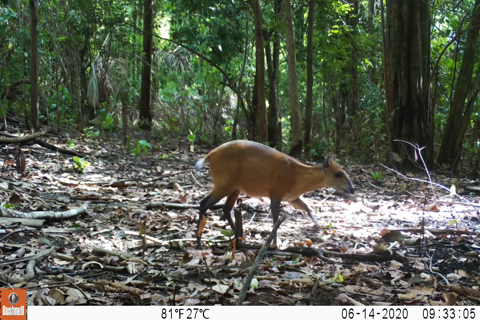

In [10]:
Image.open('vysp_frames/vysp_008.jpg').resize((480, 320))